# Diffusion!

Authors: Tejas Prabhune (inspired by CS 180)

### Assignment Goals
1. Familiarity with the U-Net architecture.
2. Familiarity with the diffusion process for image generation.
3. Practice with implimenting paper algorithms in code.

### Tasks

1. Fill in the `UnconditionalUNet` model.
2. Train the `UnconditionlUNet` model on the simple denoising task.
3. Implement the time conditioning in the `TimeConditionalUNet` model.
4. Implement the diffusion algorithms in the `DDPM` class.
5. Train a diffusion model using the `TimeConditionalUNet` module.

### Runtime Acceleration
Colab limits GPU usage, so set `device` below as `'cpu'` and change your runtime to CPU as well (Runtime > Change runtime type) when you're developing, and only change it to `'cuda'` (and your runtime to GPU) when you're ready to train.

In [6]:
#device = 'cpu'
device = 'cuda'

In [7]:
from __future__ import annotations
from enum import Enum
from dataclasses import dataclass

import argparse
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


### NoisyMNIST

This dataset will take in a noise level and spit out MNIST numbers with a certain amount of random Gaussian noise. You can take a look at the given
visualization for what this dataset will give you for different noise amounts.

Our `UnconditionalUNet` will be in charge of denoising these images so they look
crystal clear.

In [8]:
class NoisyMNIST(Dataset):
    def __init__(self, noise_level: float = 0.1, train: bool = True):
        """
        Modified MNIST dataset with a noise_level dictating how much Gaussian
        noise each image in the dataset should have.
        """
        dataset = MNIST(root="data", download=True, transform=ToTensor(), train=train)

        self.dataset = dataset
        self.noise_level = noise_level

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        x_noisy = x + self.noise_level * torch.randn_like(x)
        return x_noisy.float(), x.float()

    def __repr__(self):
        return f"NoisyMNIST(noise_level={self.noise_level})"

100%|██████████| 9.91M/9.91M [00:11<00:00, 896kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 57.8kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.89MB/s]


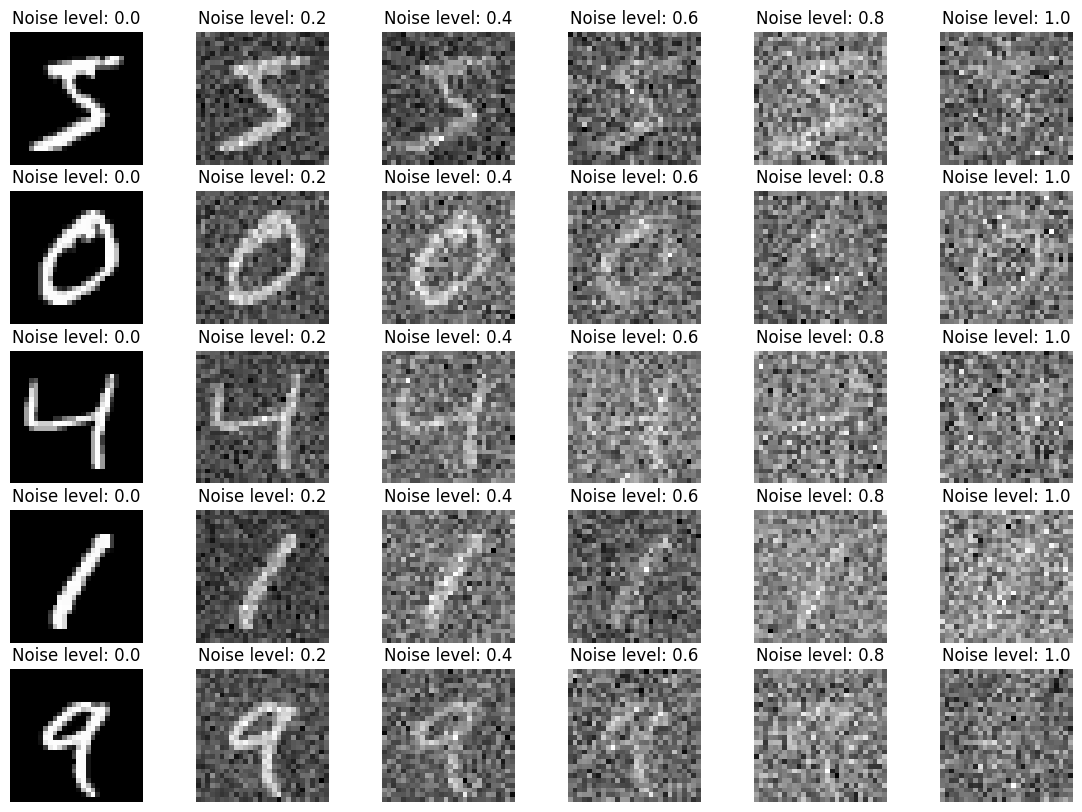

In [9]:
datasets = [NoisyMNIST(noise_level=i / 10) for i in range(0, 12, 2)]

fig, axs = plt.subplots(5, 6, figsize=(14, 10))

for j in range(5):
    for i, dataset in enumerate(datasets):
        x, _ = dataset[j]
        axs[j, i].imshow(x.squeeze(), cmap="gray")
        axs[j, i].axis("off")
        axs[j, i].set_title(f"Noise level: {dataset.noise_level}")

### Helper Layers

Here we provide you all the layers you will need to implement the U-Net model.
These layers abstract away some of the repetitive work you have to do with
activation functions and batch normalization that you have worked with in
past assignment.

The given diagram also uses these layer names, so you can closely follow the
diagram if you inspect these functions carefully.

Here is a brief reference with descriptions of each function (more details are
given in the comments for each module):

1. `Conv`: single convolution preserving size.
2. `DownConv`: single convolution halving the spatial dimension.
3. `UpConv`: single transpose convolution doubling the spatial dimension.
4. `Flatten`: pools over the spatial dimensions to create a
channel-dimensional vector.
5. `Unflatten`: single transpose convolution to restore the spatial dimensions
from a channel-dimensional vector.
6. `ConvBlock`: combination of two `Conv` blocks.
7. `DownBlock`: one `DownConv` and one `Conv` block.
8. `UpBlock`: one `UpConv` and one `Conv` block.
9. `FCBlock`: represents an MLP, has two `Linear` layers with
an activation function between.

In [10]:
class Conv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents a single convolution, batch norm, and GELU operation.
        Uses a kernel size of 3 and padding of 1.
        """
        super().__init__()

        self.conv = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=3,
                              padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents a single down convolution where the spatial dimensions
        are halved. Adds a convolution, batch norm, and GELU operation.
        Uses a kernel size of 3 and a padding of 1.
        """
        super().__init__()

        self.conv = nn.Conv2d(in_channels,
                              out_channels,
                              kernel_size=3,
                              padding=1,
                              stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents a single up convolution (transpose convolution)
        where the spatial dimensions are doubled. Adds a convolution,
        batch norm, and GELU operation. Uses a kernel size of 3
        and a padding of 1.
        """
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_channels,
                                       out_channels,
                                       kernel_size=4,
                                       padding=1,
                                       stride=2)
        self.bn = nn.BatchNorm2d(out_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class Flatten(nn.Module):
    def __init__(self):
        """
        Creates a channel-dimensional vector by pooling with
        kernel_size 7. All images with spatial dimension of
        7 will be flattened.
        """
        super().__init__()

        self.avg_pool = nn.AvgPool2d(kernel_size=7)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.avg_pool(x)
        x = self.gelu(x)
        return x


class Unflatten(nn.Module):
    def __init__(self, in_channels: int):
        """
        Restores an image with spatial dimensions 7 from a flattened
        channel-dimensional vector.
        """
        super().__init__()

        self.conv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=7)
        self.bn = nn.BatchNorm2d(in_channels)
        self.gelu = nn.GELU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        x = self.bn(x)
        x = self.gelu(x)
        return x


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents two Conv layers applied serially.
        """
        super().__init__()

        self.layers = nn.Sequential(
            Conv(in_channels, out_channels),
            Conv(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x


class DownBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents one DownConv and one Conv layer applied
        serially.
        """
        super().__init__()

        self.layers = nn.Sequential(
            DownConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents one UpConv and one Conv layer applied
        serially.
        """
        super().__init__()

        self.layers = nn.Sequential(
            UpConv(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.layers(x)
        return x

class FCBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        """
        Represents an MLP with two Linear layers and a GELU
        in between.
        """
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_channels, out_channels),
            nn.GELU(),
            nn.Linear(out_channels, out_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

### Trainer Code

We've provided the full training code for this assignment. You don't need
to worry about this, but we would encourage you to read through this to see
exactly what datasets are being used for what task and how training is
being broken down.

In [11]:
class Task(Enum):
    UNCON_UNET = 0
    TIME_UNET = 1
    CLASS_UNET = 2

    def from_str(arg: str) -> Task:
        if arg == "unconditional_unet":
            return Task.UNCON_UNET
        elif arg == "time_unet":
            return Task.TIME_UNET
        else:
            return Task.CLASS_UNET

class Data(Enum):
    MNIST = 0
    NOISY_MNIST = 1

    def from_str(arg: str) -> Data:
        if arg == "mnist":
            return Data.MNIST
        else:
            return Data.NOISY_MNIST

    def make_dataset(self, train: bool = True) -> Dataset:
        if self == Data.MNIST:
            return MNIST(root="data", download=True, transform=ToTensor(), train=train)
        else:
            return NoisyMNIST(noise_level=0.5, train=train)

@dataclass
class TrainingConfig:
    task: Task
    data: Data
    n_epochs: int
    batch_size: int = 256
    lr: float = 1e-3
    gamma: float = 0.9
    d: int = 64
    device: int | str = device

    def from_args(args: argparse.Namespace) -> TrainingConfig:
        return TrainingConfig(Task.from_str(args.task), Data.from_str(args.data), args.n_epochs)

    def new(task: str, data: str, n_epochs: int) -> TrainingConfig:
        return TrainingConfig(Task.from_str(task), Data.from_str(data), n_epochs)

    def train(self):
        if self.task == Task.UNCON_UNET:
            train_unconditional_unet(self)
        elif self.task == Task.TIME_UNET:
            train_time_unet(self)
        else:
            raise NotImplementedError("Class-conditioned U-Net training not implemented")

def plot_losses(losses: list[float], title: str) -> plt.Figure:
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

    return plt.gcf()

def train_unconditional_unet(t: TrainingConfig):
    model: UnconditionalUNet = UnconditionalUNet(1, t.d).to(t.device)
    data: NoisyMNIST = t.data.make_dataset(train=True)
    dataloader: DataLoader = DataLoader(data, batch_size=t.batch_size, shuffle=True)
    test_data: NoisyMNIST = t.data.make_dataset(train=False)
    test_dataloader: DataLoader = DataLoader(test_data, batch_size=3, shuffle=True)
    optimizer: AdamW = AdamW(model.parameters(), lr=1e-4)
    loss_fn: MSELoss = MSELoss()
    train_losses = []

    def train_step(x: Tensor, y: Tensor) -> Tensor:
        x = x.to(t.device).to(torch.float32)
        y = y.to(t.device).to(torch.float32)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        return loss

    def plot_pred(test_x: Tensor, test_y: Tensor) -> plt.Figure:
        test_y_pred = model(test_x)

        fig, axs = plt.subplots(3, 3, figsize=(6, 6))

        for i in range(3):
            axs[i, 0].imshow(test_y[i].cpu().squeeze(), cmap="gray")
            axs[i, 0].axis("off")
            axs[i, 0].set_title("Ground Truth")

            axs[i, 1].imshow(test_x[i].cpu().squeeze(), cmap="gray")
            axs[i, 1].axis("off")
            axs[i, 1].set_title("Input (sigma = 0.5)")

            axs[i, 2].imshow(test_y_pred[i].detach().cpu().squeeze(), cmap="gray")
            axs[i, 2].axis("off")
            axs[i, 2].set_title("Prediction")

        plt.show()

        return fig

    for epoch in range(t.n_epochs):
        train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}", dynamic_ncols=True)
        for x, y in train_tqdm:
            loss = train_step(x, y)
            train_losses.append(loss.item())
            train_tqdm.set_postfix(loss=loss.item())
        print(f"Epoch {epoch}, loss: {loss.item()}")

    test_x, test_y = next(iter(test_dataloader))
    test_x = test_x.to(t.device)
    test_y = test_y.to(t.device)
    fig = plot_pred(test_x, test_y)
    fig.savefig("unconditional_final.png")

    fig = plot_losses(train_losses, "Unconditional U-Net Losses")
    fig.savefig("unconditional_losses.png")

    torch.save(model.state_dict(), "unconditional_unet.pth")



## Task 1: Denoising MNIST with the Unconditional U-Net

Your first task will be to simply denoise images using a U-Net model.
We've provided a `NoisyMNIST` class defined above that spits out
MNIST images with certain levels of Gaussian noise. You'll implement
the `UnconditionalUNet` model, then train a U-Net that denoises
MNIST data with a noise level of 0.5.

Hints:
1. Remember we can `Concat` with `torch.cat` (feel free to search
for the documentation)
2. `in_channels` will always be 1 since we are using grayscale images.
3. The dimensions are given as `D, 28, 28` where `D` is represented
by `num_hiddens` and 28 is the spatial dimension of the image.
4. To increase `D` to `2D`, you can use a `Conv`.
5. To decrease/increase 28 to 14 (spatial dimension), you should use a
`DownConv` or `UpConv`, respectively.
6. You may have to save initial intermediate values in the `forward` function
to concatenate with later intermediate values (where you see dashed lines).
7. The `Conv2d` layer at the end should have kernel size 3, stride 1, padding 1.

Here is the diagram you will have to implement for the U-Net (taken
from the CS 180 diffusion project):

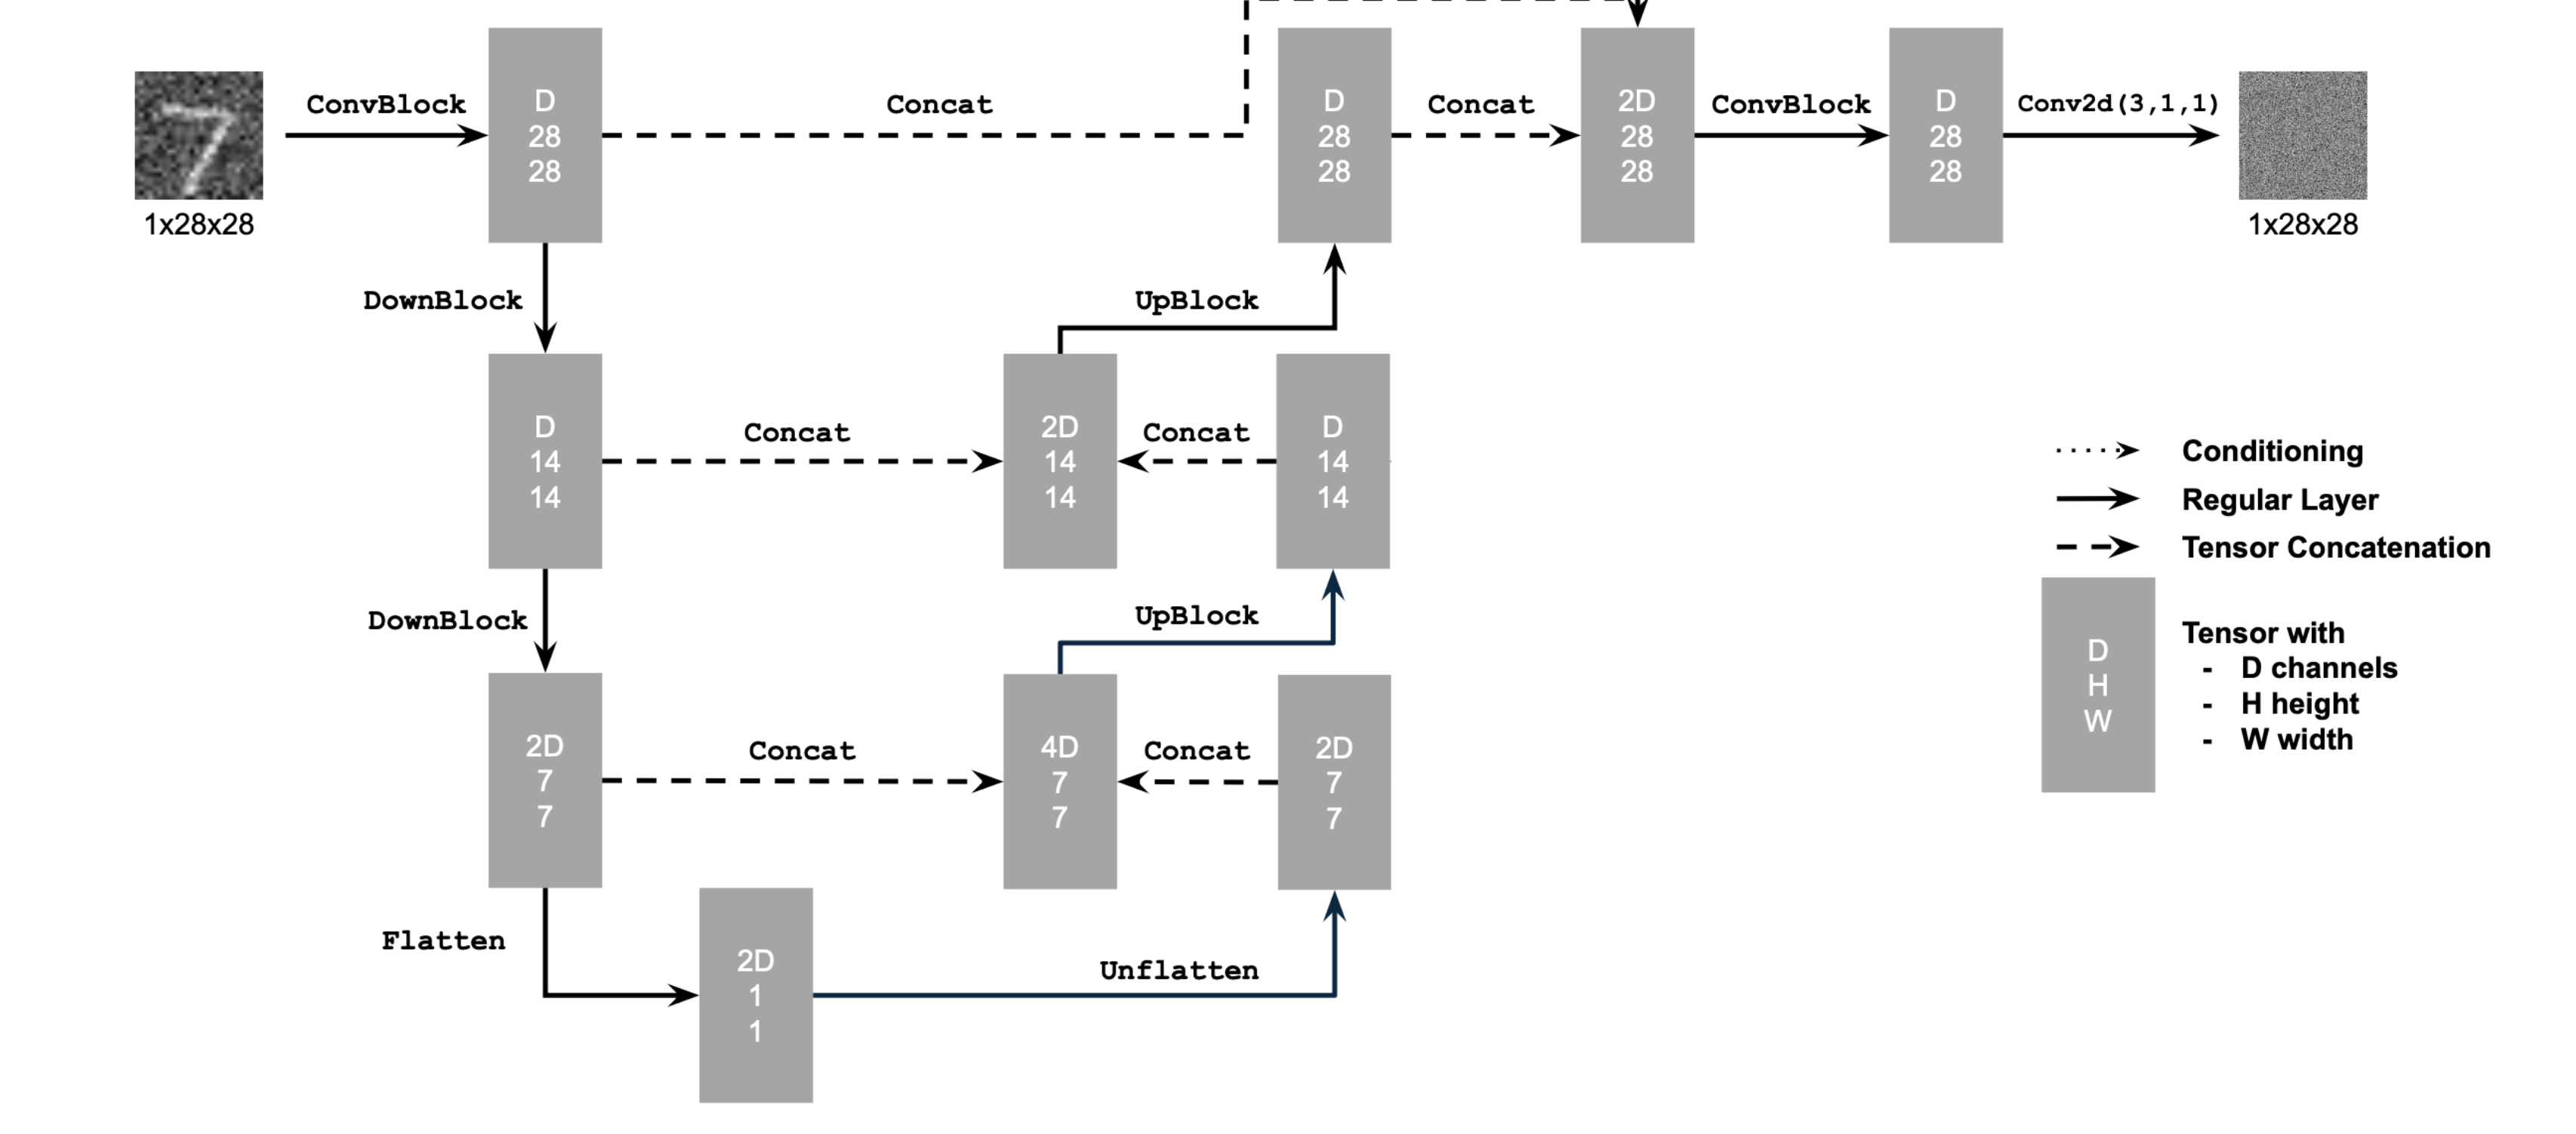

In [12]:
class UnconditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
    ):
        super().__init__()

        # ── Encoder (down) ─────────────────────────────────────
        # 28×28 → 28×28,   D channels
        self.input_conv = ConvBlock(in_channels, num_hiddens)

        # 28×28 → 14×14 → 7×7, channels: D → D → 2D
        self.down_blocks = nn.ModuleList([
            DownBlock(num_hiddens,          num_hiddens),      # (D,14,14)
            DownBlock(num_hiddens,    2 * num_hiddens),        # (2D, 7,7)
        ])

        # pool from 7×7 → 1×1
        self.flatten = Flatten()  # (2D,1,1)

        # ── Bottleneck → Decoder (up) ─────────────────────────
        # un‐flatten 1×1 → 7×7, still 2D channels
        self.unflatten = Unflatten(2 * num_hiddens)

        # upsample back to 14×14 and 28×28, each time halving channels
        self.up_blocks = nn.ModuleList([
            UpBlock(2 * num_hiddens, num_hiddens),  # (2D→D) 7×7→14×14
            UpBlock(2 * num_hiddens, num_hiddens),  # (2D→D) 14×14→28×28
        ])

        # after last up‐block we’ll concat the very first conv‐output (D→2D)
        self.final_conv_block = ConvBlock(2 * num_hiddens, num_hiddens)

        # map back down to 1 channel
        self.output_conv = nn.Conv2d(num_hiddens, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.shape[-2:] == (28, 28)

        # ── Encoder ───────────────────────────────────────────
        x0 = self.input_conv(x)           # (B,   D,28,28)
        down_outputs = []
        x1 = x0
        for db in self.down_blocks:
            x1 = db(x1)
            down_outputs.append(x1)       # [(B,D,14,14), (B,2D,7,7)]

        # ── Bottleneck ───────────────────────────────────────
        x2 = self.flatten(x1)             # (B,2D,1,1)
        x2 = self.unflatten(x2)           # (B,2D,7,7)

        # ── Decoder ───────────────────────────────────────────
        # First up‐block + skip from down_outputs[0]
        x2 = self.up_blocks[0](x2)        # (B,   D,14,14)
        x2 = torch.cat([x2, down_outputs[0]], dim=1)  # (B, 2D,14,14)

        # Second up‐block + skip from x0
        x2 = self.up_blocks[1](x2)        # (B,   D,28,28)
        x2 = torch.cat([x2, x0], dim=1)   # (B, 2D,28,28)

        # ── Final convs ───────────────────────────────────────
        x2 = self.final_conv_block(x2)    # (B,   D,28,28)
        return self.output_conv(x2)       # (B,   1,28,28)

 Train your Unconditional U-Net! We provide the training script above,
 specifying 5 epochs, which should be plenty for a sufficiently denoising
 U-Net. At the end of training, you'll see a chart showing your results.

Epoch 0: 100%|██████████| 235/235 [00:41<00:00,  5.67it/s, loss=0.0133]


Epoch 0, loss: 0.013337770476937294


Epoch 1: 100%|██████████| 235/235 [00:40<00:00,  5.78it/s, loss=0.0112]


Epoch 1, loss: 0.011154112406075


Epoch 2: 100%|██████████| 235/235 [00:40<00:00,  5.83it/s, loss=0.0103]


Epoch 2, loss: 0.01027861051261425


Epoch 3: 100%|██████████| 235/235 [00:40<00:00,  5.85it/s, loss=0.00967]


Epoch 3, loss: 0.00966587383300066


Epoch 4: 100%|██████████| 235/235 [00:40<00:00,  5.79it/s, loss=0.00916]


Epoch 4, loss: 0.00915990024805069


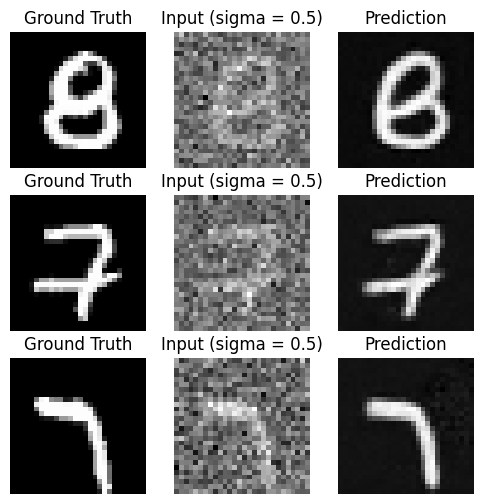

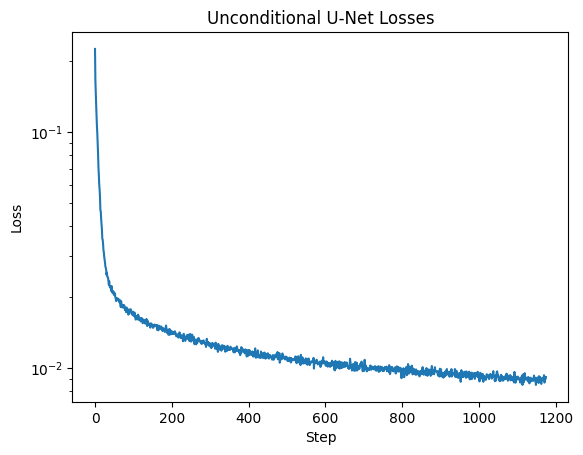

<Figure size 640x480 with 0 Axes>

In [13]:
training_config = TrainingConfig.new("unconditional_unet", "noisy_mnist", 5)
training_config.train()

## Task 2: Diffusion

Now that we've built our first denoising U-Net, it's time to progress
to full diffusion to generate brand new MNIST images.
We'll first create a `TimeConditionalUNet` adding the time conditioning
process then implement the `DDPM` class for diffusion.

### Task 2.1: Time Conditional U-Net

The first step is to briefly modify our unconditional U-Net to take in
a timestep input and condition our model on this. This step will allow us to
train a model that will predict the *noise* that was added
at a timestep rather than the actual image
itself. The diffusion process will take care of subtracting the noise at
every time step (you will implement this after!).

This model will be *almost* identical to the `UnconditionalUNet` model
(so you should copy your code over),
with one small change. We'll create an embedding for the scalar time input
and *add* it to specific parts of the U-Net. Take a look at the following
modified diagram for more details (changes are in red):

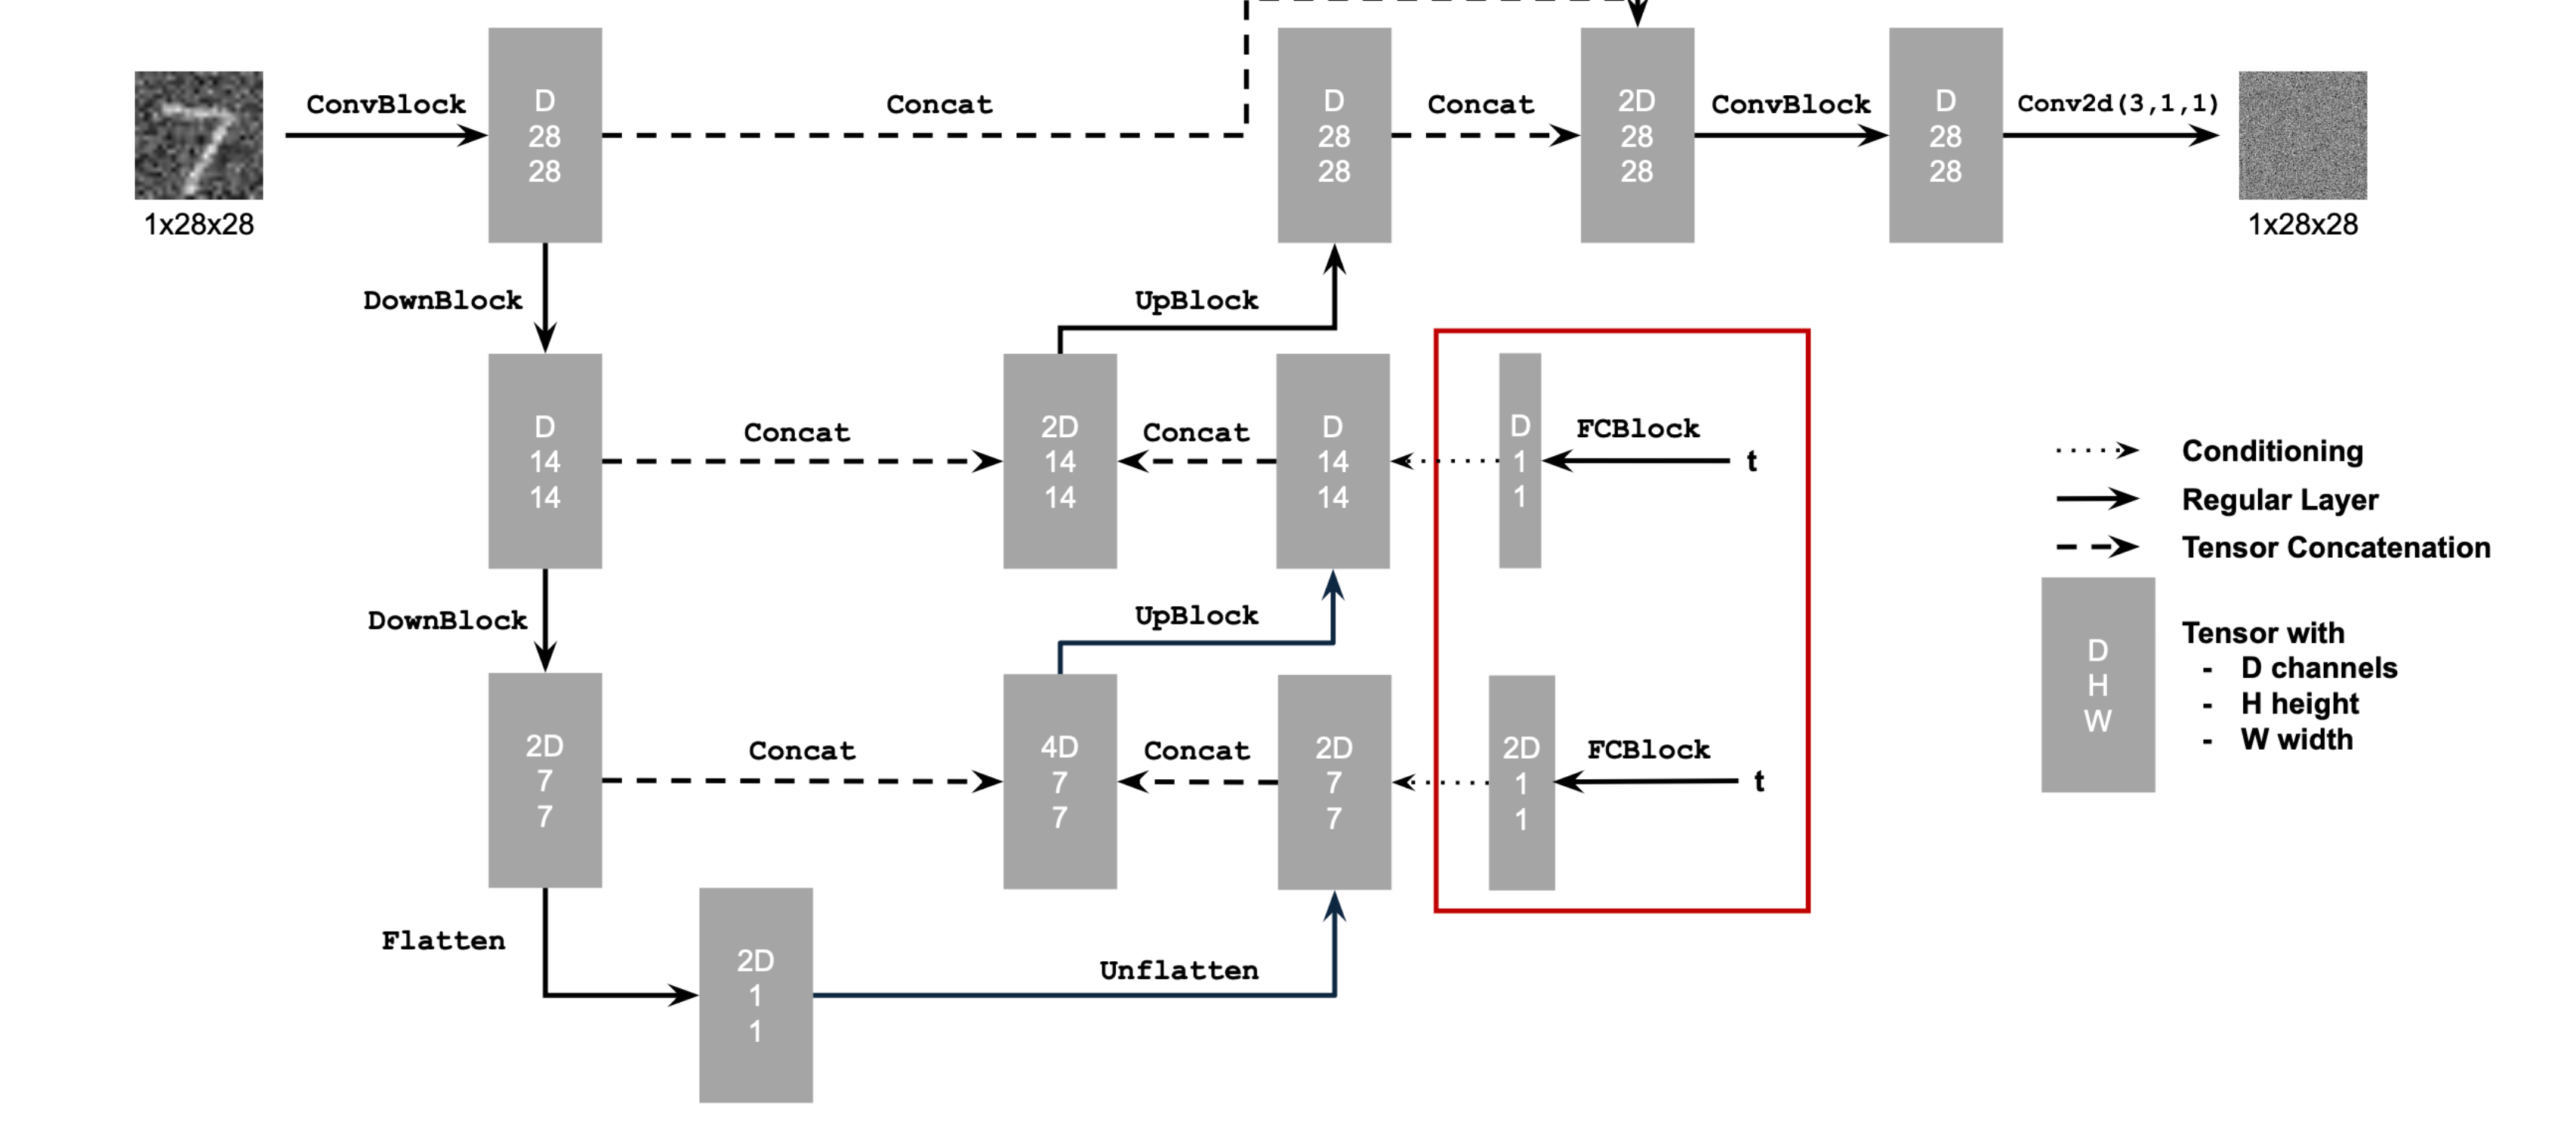

In [18]:
class TimeConditionalUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,        # unused here, but signature expects it
        num_hiddens: int,
    ):
        super().__init__()

        # ── Copy your UNet encoder ─────────────────────────────────
        self.input_conv  = ConvBlock(in_channels, num_hiddens)
        self.down_blocks = nn.ModuleList([
            DownBlock(num_hiddens,      num_hiddens),       # 28→14
            DownBlock(num_hiddens,  2*num_hiddens),         # 14→7
        ])
        self.flatten   = Flatten()                         # 7→1
        self.unflatten = Unflatten(2 * num_hiddens)        # 1→7

        # ── Copy your UNet decoder ─────────────────────────────────
        self.up_blocks = nn.ModuleList([
            UpBlock(2*num_hiddens, num_hiddens),            # 7→14
            UpBlock(2*num_hiddens, num_hiddens),            # 14→28
        ])
        self.final_conv_block = ConvBlock(2*num_hiddens, num_hiddens)
        self.output_conv      = nn.Conv2d(num_hiddens, in_channels, kernel_size=1)

        # ── Time‐conditioning MLPs ────────────────────────────────
        # turn scalar t→ embedding of size 2*num_hiddens
        self.fc_lower  = FCBlock(1, 2 * num_hiddens)
        self.fc_higher = FCBlock(1, 2 * num_hiddens)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """
        x: (N, C, 28,28)
        t: (N,)  floats in [0,1] or normalized timesteps
        """
        assert x.shape[-2:] == (28, 28)

        # ── Embed the timesteps ───────────────────────────────────
        # Make them (N,1) so FCBlock accepts them:
        t_in = t.view(-1, 1)                     # (N,1)
        t_low  = self.fc_lower(t_in)             # (N,2D)
        t_high = self.fc_higher(t_in)            # (N,2D)

        # ── Encoder ──────────────────────────────────────────────
        x0 = self.input_conv(x)                  # (N,  D,28,28)
        downs = []
        h = x0
        for db in self.down_blocks:
            h = db(h)                            # (N,  D,14,14) then (N,2D, 7,7)
            downs.append(h)

        # ── Bottleneck + add low‐level time embed ────────────────
        h = self.flatten(h)                      # (N,2D,1,1)
        h = self.unflatten(h)                    # (N,2D,7,7)
        # reshape t_low to (N,2D,1,1) and add
        h = h + t_low.view(-1, 2*h.shape[1]//2, 1, 1)

        # ── Decoder ──────────────────────────────────────────────
        # First up + skip + add high‐level time embed
        h = self.up_blocks[0](h)                 # (N,  D,14,14)
        h = torch.cat([h, downs[0]], dim=1)     # (N,2D,14,14)
        h = h + t_high.view(-1, 2*h.shape[1]//2, 1, 1)

        # Second up + skip from earliest down
        h = self.up_blocks[1](h)                 # (N,  D,28,28)
        h = torch.cat([h, x0], dim=1)            # (N,2D,28,28)

        # ── Final convolutions ───────────────────────────────────
        h = self.final_conv_block(h)             # (N,  D,28,28)
        return self.output_conv(h)               # (N,C,28,28)


### Task 2.2: Diffusion Sampling and Forward (from DDPM paper)

We'll now implement the algorithms we learned in lecture for the
sampling and forward functions. Here are the details for this section:



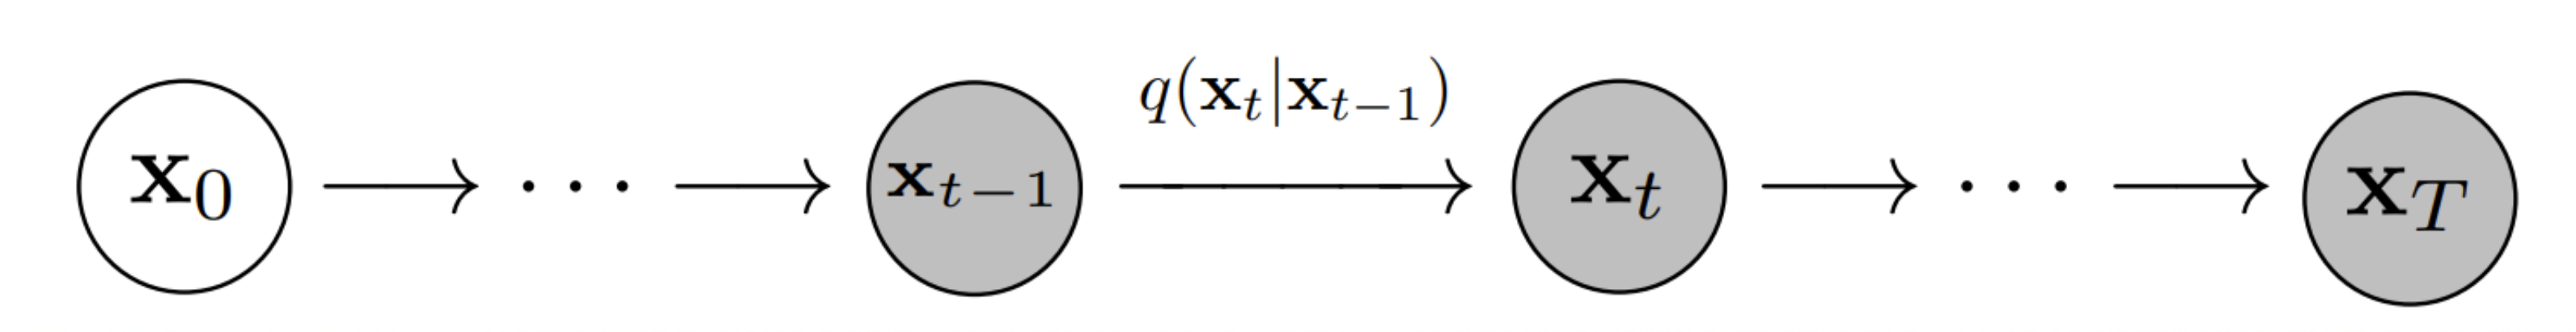

The above diagram shows the **forward process**. We take our clean input image
$x_0$ and progressively add noise to it until it represents pure noise: $x_T$.

We add noise to $x_{t-1}$ to get $x_t$ in the following way:
$$
x_t = \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{\beta_t} \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, I)
$$
Remember that all our $\{\beta_t \in (0, 1)\}^T_{t = 1}$ define our
*noise schedule*: they tell us how much noise to add at time $t$. In this
version of the forward process, we have to add noise in steps, which can
take time unnecessarily.
It turns out we can use a cool trick to start at $x_0$ and *jump* to any
time $t$ we want. If we define
$$
\alpha_t = 1 - \beta_t
$$
$$
\bar{\alpha}_t = \prod_{i = 1}^t \alpha_t
$$
we can unroll our equation to get (check lecture for derivation):
$$
x_t = \sqrt{ \bar{ \alpha }_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon
$$

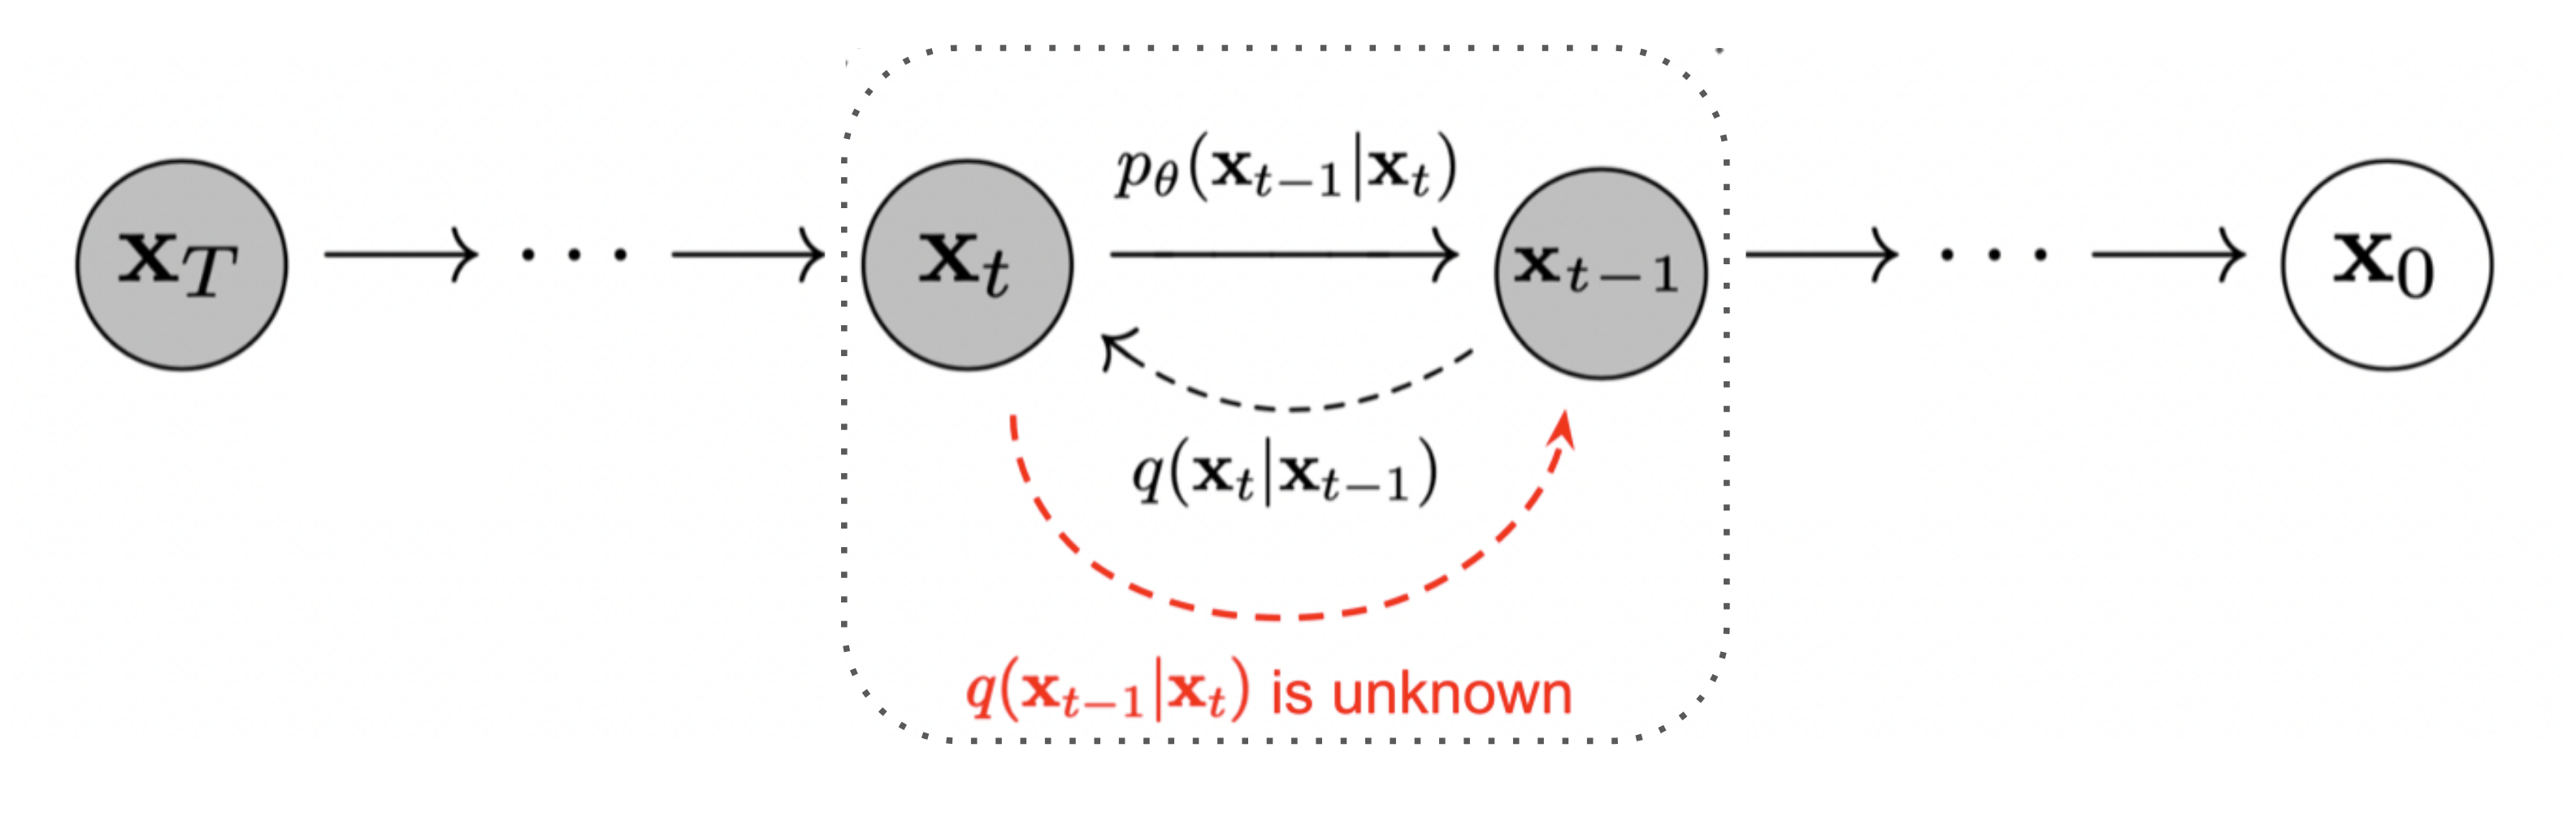

The above diagram shows the **reverse** process, where we have an image of pure
noise, $x_T$, and we will progressively *subtract* noise from it until we have
$x_0$, a clean image from our original distribution.

We won't go into the details here, but you can show that you can recover
$x_{t - 1}$ from $x_t$ by first predicting what the *original image* $x_0$
was as $\hat{x}_0$, then computing
$$
x_{t - 1} = \frac{ \sqrt{\bar{\alpha}_{t - 1} } \beta_t } {1 - \bar{ \alpha }_t } \hat{x_0} + \frac{ \sqrt{\alpha_t} (1 - \bar{\alpha}_{t - 1}) }
{1 - \bar{\alpha}_t} x_t + \sqrt{\beta_t} z
$$
where $z$ is Gaussian noise we predict for our variance term (don't worry
about deriving this).

When we sample from our diffusion model, we'll want to use this formula to
progressively subtract noise and reach a clean image.

#### Forward function:

The forward function runs through the **forward process**, uses the
U-Net to recover the noise added, and computes a loss.

You will take the initial clean image $x_0$,
select a random timestep $t$ from $\{0, \dots, T\}$, construct
the noisy image $x_t$, then use the time-conditional U-Net
to predict the noise you added and compute the loss.

1. You have the `unet`, a time-conditional U-Net that will be used to
predict the noise to subtract given an MNIST image and a timestep scalar.
2. You have a linear schedule set up for you in `ddpm_schedule`. You can take
a look at this function, but the main takeaway is that you have a
`dict` with `d_betas`: a list of $\beta$ values, `d_alphas`: a list of
$\alpha$ values, and `d_alpha_bars`: a list of the $\bar{\alpha}$
values (you'll see these in a second in the algorithm).

3. You have `x_0`, the clean MNIST image. You'll have to add noise to this
image to create `x_t` based on the algorithm first (the forward process) to then run through the reverse process.

4. You have `num_ts`, which represents $T$, the total number of timesteps.
You'll use this to generate a random $t$, the timestep for *this* iteration
of the forward function.

The full algorithm is given below:

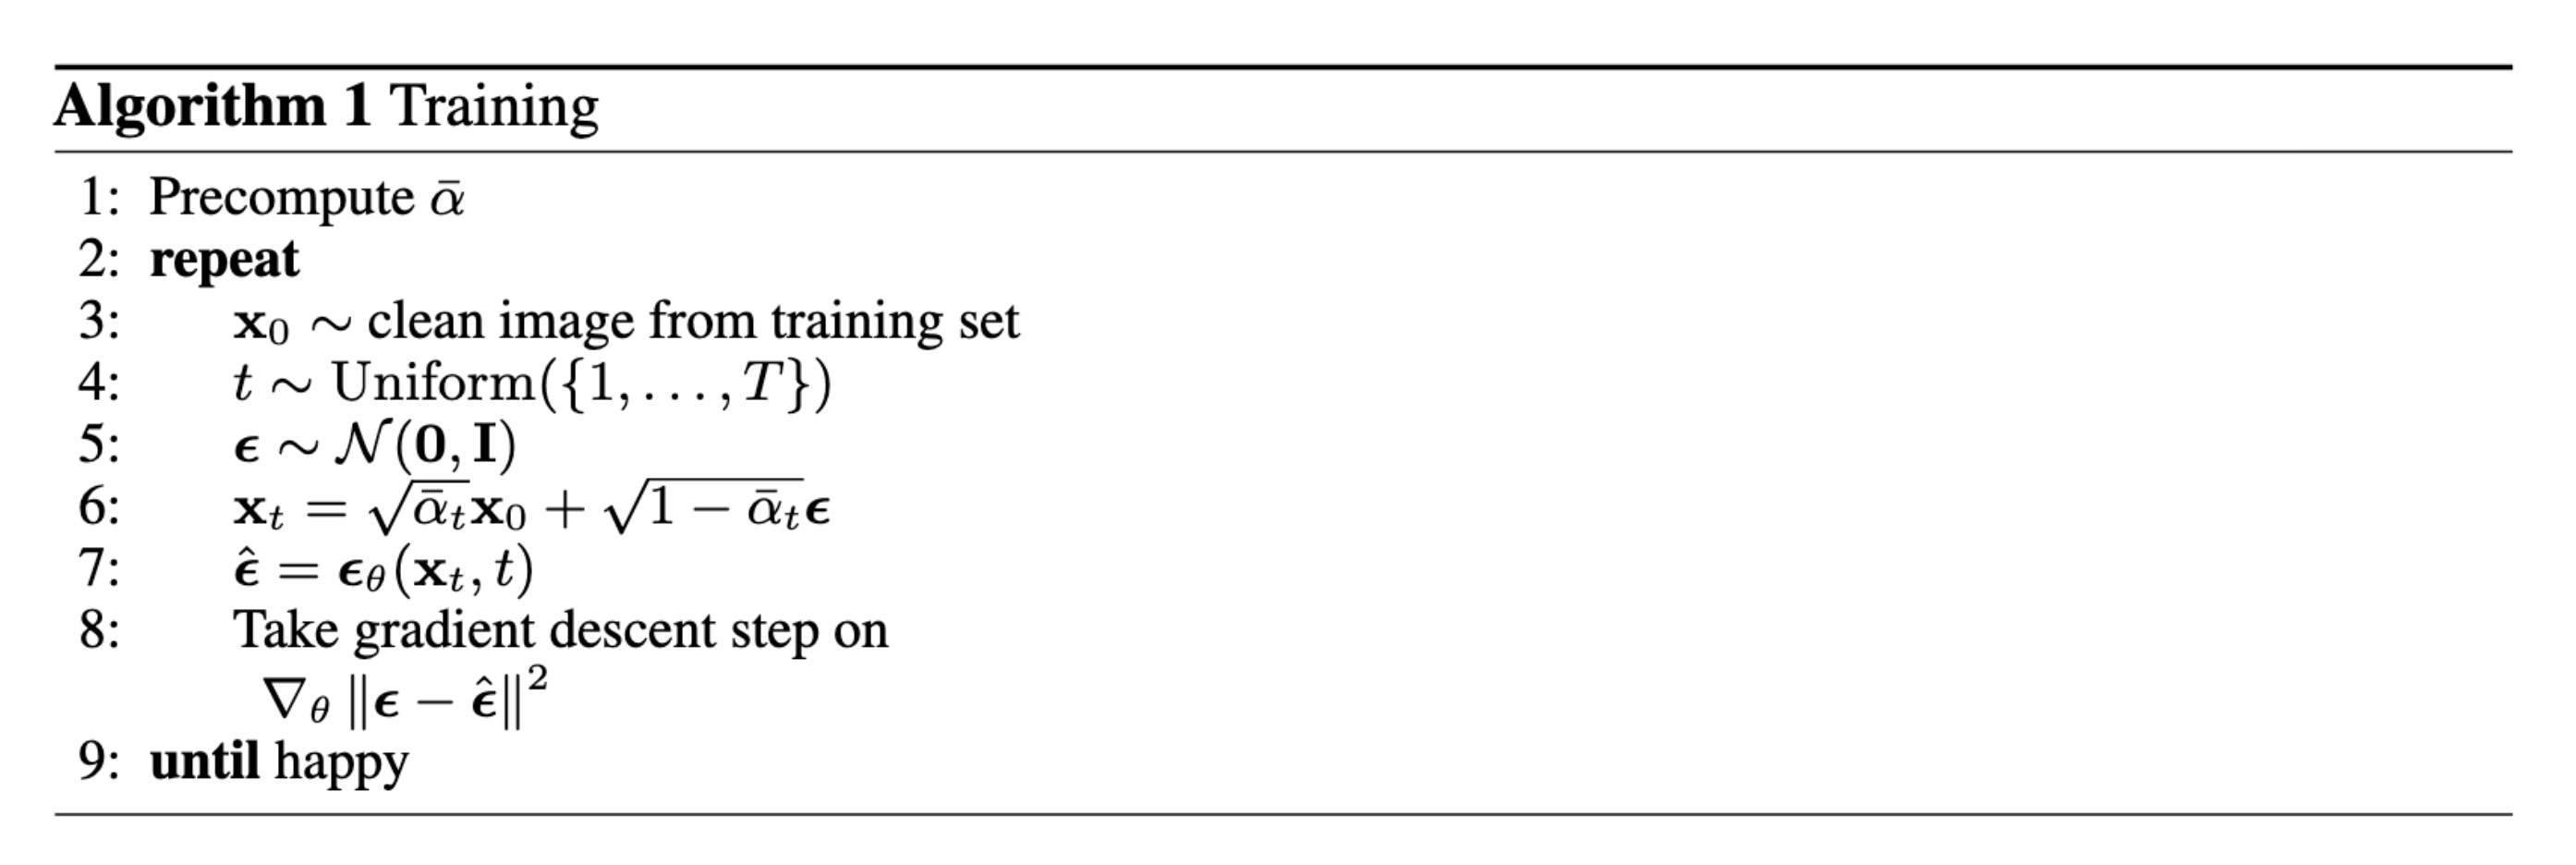

#### Sampling function:

The goal of the sampling function is to take an image of pure noise,
$x_T$, and remove noise step by step until we construct $x_0$, the
clean MNIST image (according to the sampling algorithm). We'll use
the formula in the **reverse process** section to do this sampling.

You're again given `unet`, `ddpm_schedule`, and `num_ts` from
the forward function we just implemented. In addition to this, you
are given `img_wh`, which is simply a tuple of the image width and height.
You'll need this to generate $x_T$, the initial pure noise image
that we will run the reverse process on.

Follow the algorithm provided below to implement the sampling function:

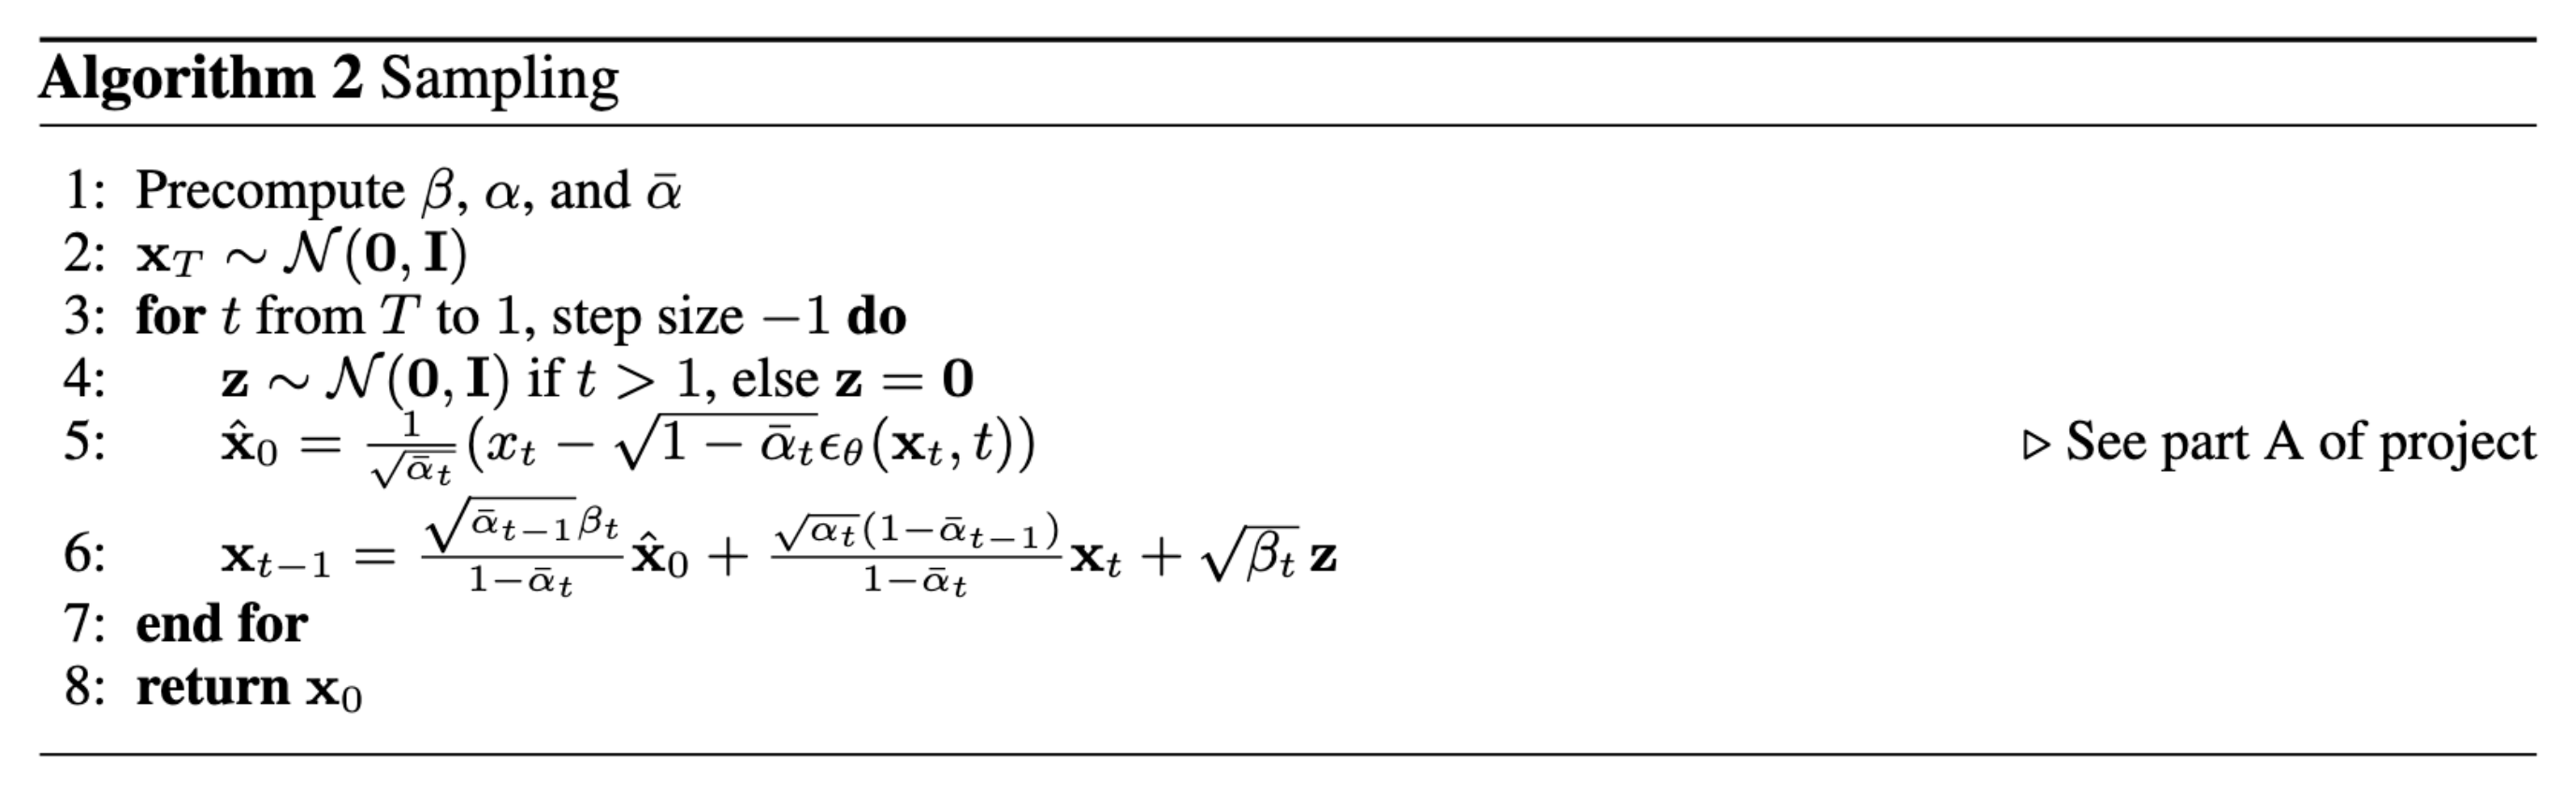

In [19]:
class DDPM(nn.Module):
    def __init__(
        self,
        unet: TimeConditionalUNet,
        betas: tuple[float, float] = (1e-4, 0.02),
        num_ts: int = 300,
        p_uncond: float = 0.1,
    ):
        super().__init__()
        self.unet = unet
        self.betas = betas
        self.num_ts = num_ts
        self.p_uncond = p_uncond
        self.ddpm_schedule = ddpm_schedule(betas[0], betas[1], num_ts)

        for k, v in ddpm_schedule(betas[0], betas[1], num_ts).items():
            self.register_buffer(k, v, persistent=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, C, H, W) input tensor.

        Returns:
            (,) diffusion loss.
        """
        return ddpm_forward(
            self.unet, self.ddpm_schedule, x, self.num_ts
        )

    @torch.inference_mode()
    def sample(
        self,
        img_wh: tuple[int, int],
        seed: int = 0,
    ):
        return ddpm_sample(
            self.unet, self.ddpm_schedule, img_wh, self.num_ts, seed
        )

def ddpm_schedule(beta1: float, beta2: float, num_ts: int) -> dict:
    """Constants for DDPM training and sampling.

    Arguments:
        beta1: float, starting beta value.
        beta2: float, ending beta value.
        num_ts: int, number of timesteps.

    Returns:
        dict with keys:
            betas: linear schedule of betas from beta1 to beta2.
            alphas: 1 - betas.
            alpha_bars: cumulative product of alphas.
    """
    assert beta1 < beta2 < 1.0, "Expect beta1 < beta2 < 1.0."

    betas = torch.linspace(beta1, beta2, num_ts)
    alphas = 1.0 - betas
    alpha_bars = torch.cumprod(alphas, dim=0)

    return {
        "d_betas": betas,
        "d_alphas": alphas,
        "d_alpha_bars": alpha_bars,
    }

def ddpm_forward(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    x_0: torch.Tensor,
    num_ts: int,
    display=False
) -> torch.Tensor:
    """Algorithm 1 of the DDPM paper.

    Args:
        unet: TimeConditionalUNet
        ddpm_schedule: dict
        x_0: (N, C, H, W) input tensor.
        num_ts: int, number of timesteps.
    Returns:
        (,) diffusion loss.
    """
    unet.train()

    alpha_bars = ddpm_schedule["d_alpha_bars"]

    # Sample a random t from 0 to num_ts
    t = torch.randint(0, num_ts, (x_0.shape[0],))

    # Retrieve our alpha_bar_t and normalize our t by num_ts (to be from 0 to 1)
    alpha_bars_t = alpha_bars[t].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).to(x_0.device)
    t = (t / (num_ts)).unsqueeze(-1).to(x_0.device)

    # Create Gaussian noise the same shape as x_0
    epsilon = torch.randn_like(x_0)

    # Use the training algorithm to create x_t (step 6)
    x_t = alpha_bars_t.sqrt() * x_0 + (1.0 - alpha_bars_t).sqrt() * epsilon

    # Pass x_t and t through the unet to get epsilon_hat
    epsilon_hat = unet(x_t, t)

    # Compute the loss between epsilon and epsilon_hat
    loss = nn.MSELoss()(epsilon, epsilon_hat)

    return loss

@torch.inference_mode()
def ddpm_sample(
    unet: TimeConditionalUNet,
    ddpm_schedule: dict,
    img_wh: tuple[int, int],
    num_ts: int,
    seed: int = 0,
) -> torch.Tensor:
    unet.eval()

    betas      = ddpm_schedule["d_betas"]
    alpha_bars = ddpm_schedule["d_alpha_bars"]

    x_t = torch.randn(1, 1, img_wh[0], img_wh[1], device=next(unet.parameters()).device)

    for t in range(num_ts - 1, 0, -1):
        # 1) noise term
        z = torch.randn_like(x_t) if t > 1 else torch.zeros_like(x_t)

        # 2) normalize timestep for conditioning
        input_t = torch.tensor(t / num_ts, device=x_t.device).unsqueeze(-1).unsqueeze(-1)

        # 3) predict noise
        epsilon_hat = unet(x_t, input_t)

        # 4) estimate x_0
        a_bar = alpha_bars[t]
        x_0_hat = (x_t - (1 - a_bar).sqrt() * epsilon_hat) / a_bar.sqrt()

        # 5) compute previous x
        a_bar_prev = alpha_bars[t - 1]
        x_t_1 = (
            a_bar_prev.sqrt() * x_0_hat
            + (1 - a_bar_prev).sqrt() * epsilon_hat
            + betas[t].sqrt() * z
        )

        x_t = x_t_1

    return x_t


 Code for training your `DDPM` model!

In [20]:
def train_time_unet(t: TrainingConfig):
    model: TimeConditionalUNet = TimeConditionalUNet(1, 1, t.d).to(t.device)
    ddpm: DDPM = DDPM(unet=model).to(t.device)

    data: MNIST = t.data.make_dataset(train=True)
    dataloader: DataLoader = DataLoader(data, batch_size=t.batch_size, shuffle=True)
    optimizer: AdamW = AdamW(ddpm.parameters(), lr=1e-3)
    scheduler: ExponentialLR = ExponentialLR(optimizer, gamma=t.gamma)
    train_losses = []

    def train_step(x: Tensor) -> Tensor:
        x = x.to(t.device).float()
        optimizer.zero_grad()
        loss = ddpm(x)
        loss.backward()
        optimizer.step()
        return loss

    def plot_pred() -> plt.Figure:
        fig, axs = plt.subplots(4, 10, figsize=(9, 3))

        plot_tqdm = tqdm(range(40), desc="Plotting samples")
        for i in range(4):
            for j in range(10):
                x = ddpm.sample((28, 28))
                axs[i, j].imshow(x.squeeze().detach().cpu(), cmap="gray")
                axs[i, j].axis("off")
                plot_tqdm.update(1)
        plot_tqdm.close()

        plt.show()

        return fig

    ddpm.train()
    ddpm = ddpm.to(t.device)
    model = model.to(t.device)
    for epoch in range(5):
        train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}")
        for x, _ in train_tqdm:
            x = x.to(t.device)
            loss = train_step(x)
            train_losses.append(loss.item())
            train_tqdm.set_postfix(loss=loss.item())
        scheduler.step()

    fig = plot_pred()
    fig.savefig("time_conditional_5_epochs.png")

    ddpm.train()
    ddpm = ddpm.to(t.device)
    model = model.to(t.device)
    for epoch in range(5, t.n_epochs):
        train_tqdm = tqdm(dataloader, desc=f"Epoch {epoch}")
        for x, _ in train_tqdm:
            x = x.to(t.device)
            loss = train_step(x)
            train_losses.append(loss.item())
            train_tqdm.set_postfix(loss=loss.item())
        scheduler.step()

    fig = plot_pred()
    fig.savefig("time_conditional_final.png")

    fig = plot_losses(train_losses, "Time-conditional U-Net Losses")
    fig.savefig("time_conditional_losses.png")

    torch.save(model.state_dict(), "time_conditional_unet.pth")

 Train your diffusion model! We provide the training script above,
 specifying 20 epochs. You'll see a progress chart at 5 epochs and
 a final chart at 20 epochs (end of training).

Plotting samples: 100%|██████████| 40/40 [00:40<00:00,  1.00s/it]


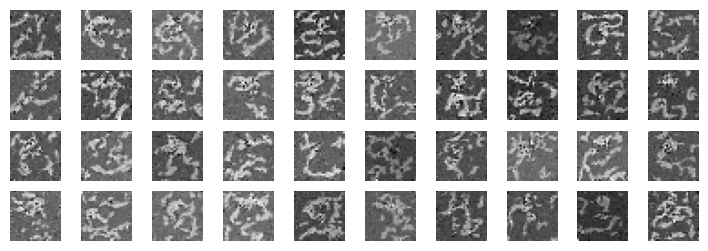

Plotting samples: 100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


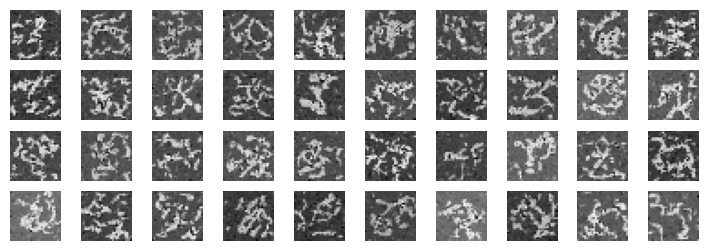

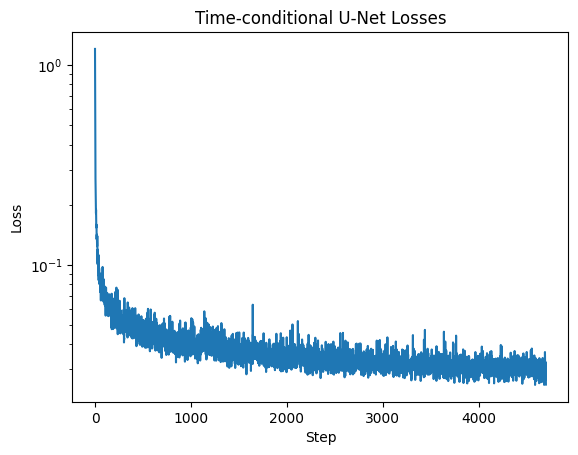

<Figure size 640x480 with 0 Axes>

In [21]:
training_config = TrainingConfig.new("time_unet", "mnist", 20)
training_config.train()

## Submission

For submission, you just need to submit the downloaded `.ipynb` file for this
Colab notebook! We should see the full implementation of your code
and all the charts should be plotted. Hope you all had fun with a
homework that's a bit more involved!